In [83]:
# library for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from sklearn.model_selection import train_test_split 

import os 

## Data preparation

In [ ]:
# ratings = pd.read_csv('../dataset/integration_to_db/merge_ratings.csv')
ratings = pd.read_csv('../dataset/review_wisata.csv')
destination = pd.read_csv('../dataset/destination.csv')

In [138]:
ratings = ratings.sort_values('user_wisata', ascending=True)
ratings

,user_wisata,wisata_id,wisata_rating
0,1,179,3
29,1,328,2
28,1,48,2
27,1,302,2
26,1,307,4
...,...,...,...
9975,300,221,3
9974,300,397,2
9998,300,279,4
9985,300,8,1


In [139]:
ratings = ratings.sort_values('wisata_rating', ascending=False).drop_duplicates(subset=['wisata_id', 'user_wisata'], keep='first')

In [140]:
ratings.shape

(9597, 3)

In [144]:
train, test = train_test_split(ratings, test_size = 0.2)

In [146]:
number_user = len(ratings['user_wisata'].unique())
number_destination = len(ratings['wisata_id'].unique())

print(f'number of user = {number_user}')
print(f'number of place name = {number_destination}')

number of user = 300
number of place name = 437


## Model

In [151]:
# build recommendation system using emmbedding layers dan dropout(to overcome the overfitting)

from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense, Dropout 

EMBEDDING_DIM = 50

# input layers 
place_input = Input(shape=[1])
user_input = Input(shape=[1])

# embedding layers add dropout 
place_embedding = Embedding(number_destination+1 , EMBEDDING_DIM)(place_input)
place_embedding = Dropout(0.2)(place_embedding)

user_embedding = Embedding(number_user+1 , EMBEDDING_DIM)(user_input)
user_embedding = Dropout(0.2)(user_embedding)

# flatten the embedddings
place_flat = Flatten()(place_embedding)
user_flat = Flatten()(user_embedding)

# output layer
output = Dot(1)([place_flat, user_flat])

# the model
model = Model([place_input, user_input], [output])

In [152]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer=Adam(learning_rate = 0.0005), loss='mean_squared_error') 

In [153]:
history = model.fit(x= [train.wisata_id, train.user_wisata], 
                    y= train.wisata_rating, 
                    validation_data = ([train.wisata_id, train.user_wisata], train.wisata_rating), 
                    epochs =200,
                    callbacks=[early_stopping],)

Epoch 1/200
240/240 [==============================] - 2s 4ms/step - loss: 11.5171 - val_loss: 11.4940
Epoch 2/200
240/240 [==============================] - 1s 3ms/step - loss: 11.4906 - val_loss: 11.4583
Epoch 3/200
240/240 [==============================] - 1s 3ms/step - loss: 11.4424 - val_loss: 11.3852
Epoch 4/200
240/240 [==============================] - 1s 3ms/step - loss: 11.3331 - val_loss: 11.2107
Epoch 5/200
240/240 [==============================] - 1s 3ms/step - loss: 11.0686 - val_loss: 10.8170
Epoch 6/200
240/240 [==============================] - 1s 3ms/step - loss: 10.5194 - val_loss: 10.0774
Epoch 7/200
240/240 [==============================] - 1s 3ms/step - loss: 9.5909 - val_loss: 8.9477
Epoch 8/200
240/240 [==============================] - 1s 3ms/step - loss: 8.3335 - val_loss: 7.5374
Epoch 9/200
240/240 [==============================] - 1s 3ms/step - loss: 6.8808 - val_loss: 6.0436
Epoch 10/200
240/240 [==============================] - 1s 3ms/step - loss: 5.4

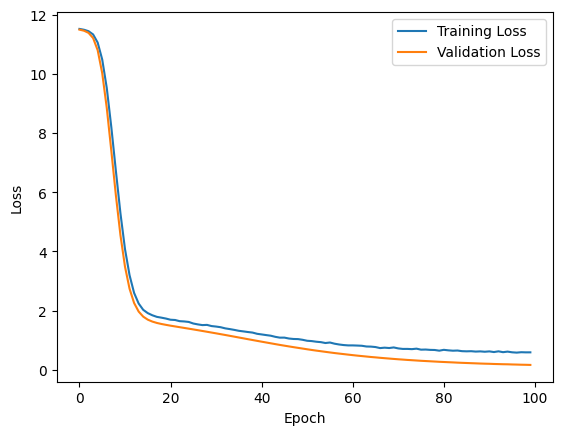

In [150]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [159]:
# calculations for "haversine distance" and complementary functions for collaborative filtering
from math import radians

def haversine_distance(lat1, long1, lat2, long2):
    earth_radius = 6371  # Radius of the Earth in kilometers (source: google)
    lat1_rad = np.radians(lat1)
    long1_rad = np.radians(long1)
    lat2_rad = np.radians(lat2)
    long2_rad = np.radians(long2)
    diff_lat = lat2_rad - lat1_rad
    diff_long = long2_rad - long1_rad
    a = np.sin(diff_lat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(diff_long / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = earth_radius * c
    return distance

def filter_by_location(destination, user_lat, user_long, max_distance):
    destination['distance'] = haversine_distance(destination['destination_lat'], destination['destination_long'], user_lat, user_long)
    destination = destination[destination['distance'] <= max_distance]
    destination = destination.drop('distance', axis=1)
    return destination

def filter_by_city(destination):
    city_filter = ['Jakarta', 'Bandung', 'Yogyakarta', 'Semarang', 'Surabaya']
    destination = destination[destination['city'].isin(city_filter)]
    return destination

In [160]:
# recommendation system function using collaborative filtering
def collaborative_rec(User_Id, destination ,model, u_lat, u_long, np_val = 6 ):
    """
        User_Id : untuk melakukan rekomendasi berdasarkan User_Id yang diberikan
        destinatin : dataframe dengan format column terdapat "user_wisata, wisata_id, wisata_rating, name_wisata, category, description_wisata, destination_lat, destination_long, destination_photo, city"
        model : model hasil yang sudah di training sebelumnya
        np_val : banyaknya output yang akan diberikan
        u_lat & u_long : berguna untuk menentukan destinasi wisata terdekat dari lat & long yang diberikan
    """
    
    if User_Id in ratings['user_wisata'].values:
            destination = destination.copy()
            user_ids = np.array([User_Id] * len(destination))
            results = model([destination.id.values, user_ids]).numpy().reshape(-1)
    
            destination['predicted_rating'] = pd.Series(results)
            destination = filter_by_location(destination, u_lat, u_long, 30)[:20]
            destination = destination.sort_values('predicted_rating', ascending = False)
    else:
            destination = destination.copy()
            destination = destination.sort_values('rating', ascending = False)  
    
    return destination[:np_val].to_dict(orient='records')

## Output

In [161]:
user_location = 'Bandung'
user_lat = -6.89714
user_long = 107.6558

In [162]:
final_result = collaborative_rec(1, destination, model, user_lat, user_long, )
final_result

[{'id': 223,
  'name_wisata': 'Masjid Raya Bandung',
  'description_wisata': 'Masjid Raya Bandung Provinsi Jawa Barat yang dulu dikenal dengan nama Masjid Agung Bandung adalah masjid yang berada di Kota Bandung Jawa Barat Indonesia Status masjid ini adalah sebagai masjid provinsi bagi Jawa Barat Masjid ini pertama dibangun tahun 1810 dan sejak didirikannya Masjid Agung telah mengalami delapan kali perombakan pada abad ke19 kemudian lima kali pada abad 20 sampai akhirnya direnovasi lagi pada tahun 2001 sampai peresmian Masjid Raya Bandung 4 Juni 2003 yang diresmikan oleh Gubernur Jabar saat itu HR Nuriana Masjid baru ini yang bercorak Arab menggantikan Masjid Agung yang lama yang bercorak khas SundanMasjid Raya Bandung seperti yang kita lihat sekarang terdapat dua menara kembar di sisi kiri dan kanan masjid setinggi 81 meter yang selalu dibuka untuk umum setiap hari Sabtu dan Minggu Atap masjid diganti dari atap joglo menjadi satu kubah besar pada atap tengah dan yang lebih kecil pada a

## Pretraining model

In [ ]:
# tf.keras.models.save_model(model, 'pretrained_collab_rec')

In [ ]:
# Example of loading pretrained model

model =  tf.keras.models.load_model('pretrained_collab_rec')

# pretrained_result = collaborative_rec(34, destination, loaded_model, user_lat, user_long)
# print(pretrained_result==final_result)

In [ ]:
pretrained_result = collaborative_rec(34, destination, model, user_lat, user_long)

In [ ]:
len(pretrained_result)

In [ ]:
model.summary()

In [ ]:
loaded_model.summary()